In [1]:
import numpy as np

import pandas as pd

import cv2 as cv

import matplotlib.pyplot as plt

import skimage.io as io

import skimage as sk

from skimage.feature import greycomatrix, greycoprops
from skimage import data

from skimage.filters import threshold_otsu

import scipy




In [2]:
image=io.imread('ACdata_base/1/0001.jpg',as_gray=True)

In [3]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 

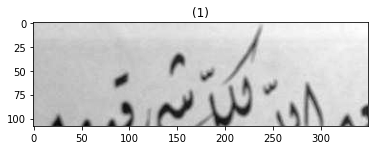

In [4]:
show_images([image[:int(image.shape[0]/2),:int(image.shape[1]/2)]])

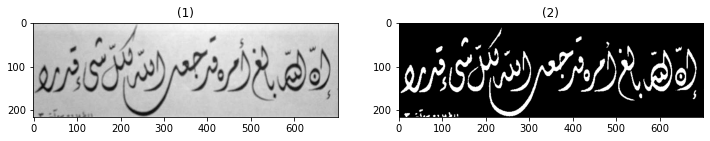

In [5]:

image_temp=np.copy(image)

threshold=threshold_otsu(image)

image_temp[image_temp>threshold]=1

image_temp[image_temp<threshold]=0

image_final=np.copy(image_temp)

image_final[image_temp==0]=1

image_final[image_temp==1]=0

show_images([image,image_final])

In [6]:
scipy.signal.stft(image_final)

(array([0.        , 0.00390625, 0.0078125 , 0.01171875, 0.015625  ,
        0.01953125, 0.0234375 , 0.02734375, 0.03125   , 0.03515625,
        0.0390625 , 0.04296875, 0.046875  , 0.05078125, 0.0546875 ,
        0.05859375, 0.0625    , 0.06640625, 0.0703125 , 0.07421875,
        0.078125  , 0.08203125, 0.0859375 , 0.08984375, 0.09375   ,
        0.09765625, 0.1015625 , 0.10546875, 0.109375  , 0.11328125,
        0.1171875 , 0.12109375, 0.125     , 0.12890625, 0.1328125 ,
        0.13671875, 0.140625  , 0.14453125, 0.1484375 , 0.15234375,
        0.15625   , 0.16015625, 0.1640625 , 0.16796875, 0.171875  ,
        0.17578125, 0.1796875 , 0.18359375, 0.1875    , 0.19140625,
        0.1953125 , 0.19921875, 0.203125  , 0.20703125, 0.2109375 ,
        0.21484375, 0.21875   , 0.22265625, 0.2265625 , 0.23046875,
        0.234375  , 0.23828125, 0.2421875 , 0.24609375, 0.25      ,
        0.25390625, 0.2578125 , 0.26171875, 0.265625  , 0.26953125,
        0.2734375 , 0.27734375, 0.28125   , 0.28

In [31]:
import numpy as np
from scipy.signal import convolve2d
import cv2
import matplotlib.pyplot as plt


def lpq(img, winSize=3, freqestim=1, mode='nh'):
    rho = 0.90

    STFTalpha = 1 / winSize  # alpha in STFT approaches (for Gaussian derivative alpha=1)
    '''
    sigmaS = (winSize - 1) / 4  # Sigma for STFT Gaussian window (applied if freqestim==2)
    sigmaA = 8 / (winSize - 1)  # Sigma for Gaussian derivative quadrature filters (applied if freqestim==3)
    '''

    convmode = 'valid'  # Compute descriptor responses only on part that have full neigborhood. Use 'same' if all pixels are included (extrapolates np.image with zeros).

    img = np.float64(img)  # Convert np.image to double
    r = (winSize - 1) / 2  # Get radius from window size
    x = np.arange(-r, r + 1)[np.newaxis]  # Form spatial coordinates in window

    if freqestim == 1:  # STFT uniform window
        #  Basic STFT filters
        w0 = np.ones_like(x)
        w1 = np.exp(-2 * np.pi * x * STFTalpha * 1j)
        w2 = np.conj(w1)

    # Run filters to compute the frequency response in the four points. Store np.real and np.imaginary parts separately
    # Run first filter
    filterResp1 = convolve2d(convolve2d(img, w0.T, convmode), w1, convmode)
    filterResp2 = convolve2d(convolve2d(img, w1.T, convmode), w0, convmode)
    filterResp3 = convolve2d(convolve2d(img, w1.T, convmode), w1, convmode)
    filterResp4 = convolve2d(convolve2d(img, w1.T, convmode), w2, convmode)

    # Initilize frequency domain matrix for four frequency coordinates (np.real and np.imaginary parts for each frequency).
    freqResp = np.dstack([filterResp1.real, filterResp1.imag,
                          filterResp2.real, filterResp2.imag,
                          filterResp3.real, filterResp3.imag,
                          filterResp4.real, filterResp4.imag])

    # Perform quantization and compute LPQ codewords
    inds = np.arange(freqResp.shape[2])[np.newaxis, np.newaxis, :]
    LPQdesc = ((freqResp > 0) * (2 ** inds)).sum(2)

    # Switch format to uint8 if LPQ code np.image is required as output
    if mode == 'im':
        LPQdesc = np.uint8(LPQdesc)

    # Histogram if needed
    if mode == 'nh' or mode == 'h':
        LPQdesc = np.histogram(LPQdesc.flatten(), range(256))[0]

    # Normalize histogram if needed
    if mode == 'nh':
        LPQdesc = LPQdesc / LPQdesc.sum()

    # print(len(LPQdesc))
    # plt.plot(LPQdesc)
    # plt.show()
    return LPQdesc




255


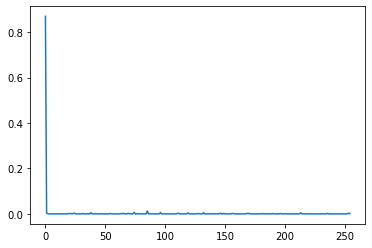

[array([8.70405305e-01, 3.40136054e-03, 1.02898302e-03, 0.00000000e+00,
       5.71657234e-05, 4.00160064e-04, 0.00000000e+00, 0.00000000e+00,
       2.85828617e-05, 2.85828617e-05, 2.85828617e-05, 0.00000000e+00,
       5.71657234e-05, 2.57245755e-04, 0.00000000e+00, 0.00000000e+00,
       1.42914309e-04, 1.42914309e-04, 0.00000000e+00, 1.08614875e-03,
       1.42914309e-03, 2.05796604e-03, 5.71657234e-05, 1.25764592e-03,
       3.63002344e-03, 2.85828617e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.85828617e-05, 2.02938318e-03,
       0.00000000e+00, 0.00000000e+00, 5.14491511e-04, 5.71657234e-05,
       0.00000000e+00, 0.00000000e+00, 5.65940662e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.42914309e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.85828617e-05, 7.43154405e-04,
       2.85828617e-05, 2.85828617e-05, 0.00000000e+00, 2.85828617e-05,
       0.00000000e+00, 2.85828617e-05, 1.91505173e-03, 5.71657234e-04,
     

In [20]:
dataset=[]

image=io.imread('ACdata_base/2/0191.jpg',as_gray=True)

image_temp=np.copy(image)

threshold=threshold_otsu(image)

image_temp[image_temp>threshold]=1

image_temp[image_temp<threshold]=0

image_final=np.copy(image_temp)

image_final[image_temp==0]=1

image_final[image_temp==1]=0

# img = ndimage.imread('image1.jpg')
# print(gray)
LPQdesc=lpq(image_final)

dataset.append(LPQdesc)

print(dataset)

In [ ]:
# Loading images


In [39]:
def outsu(image):
    image_temp=np.copy(image)

    threshold=threshold_otsu(image)

    image_temp[image_temp>threshold]=1

    image_temp[image_temp<threshold]=0

    image_final=np.copy(image_temp)

    image_final[image_temp==0]=1

    image_final[image_temp==1]=0

    return image_final
    


In [44]:
dataset=[]

X_train=[]

labels=[]

path="ACdata_base"

idx=1

# slash='\\'

rest="\\1\\000"

for idx in range (1,191):


    if (idx>9 and idx <99):
        rest="\\1\\00"

    if (idx>99 and idx <999):
        rest="\\1\\0"

    image=io.imread(path+rest+str(idx)+'.jpg',as_gray=True)

    image_final=outsu(image)

    LPQdesc=lpq(image_final)

    dataset.append(LPQdesc)

    labels.append(1)



for idx in range (191,381):

    rest="\\2\\0"

    image=io.imread(path+rest+str(idx)+'.jpg',as_gray=True)

    image_final=outsu(image)

    LPQdesc=lpq(image_final)

    dataset.append(LPQdesc)

    labels.append(2)



for idx in range (381,561):

    rest="\\3\\0"


    image=io.imread(path+rest+str(idx)+'.jpg',as_gray=True)

    image_final=outsu(image)

    LPQdesc=lpq(image_final)

    dataset.append(LPQdesc)

    labels.append(3)


for idx in range (561,746):

    rest="\\4\\0"

    image=io.imread(path+rest+str(idx)+'.jpg',as_gray=True)

    image_final=outsu(image)

    LPQdesc=lpq(image_final)

    dataset.append(LPQdesc)

    labels.append(4)



for idx in range (746,941):

    rest="\\5\\"

    image=io.imread(path+rest+str(idx)+'.jpg',as_gray=True)

    image_final=outsu(image)

    LPQdesc=lpq(image_final)

    dataset.append(LPQdesc)

    labels.append(5)



for idx in range (941,1121):

    rest="\\6\\0"

    if (idx>999):
        rest="\\6\\"

    image=io.imread(path+rest+str(idx)+'.jpg',as_gray=True)

    image_final=outsu(image)

    LPQdesc=lpq(image_final)

    dataset.append(LPQdesc)

    labels.append(6)


for idx in range (1121,1306):

    rest="\\7\\"


    image=io.imread(path+rest+str(idx)+'.jpg',as_gray=True)

    image_final=outsu(image)

    LPQdesc=lpq(image_final)

    dataset.append(LPQdesc)

    labels.append(7)




for idx in range (1306,1496):

    rest="\\8\\"


    image=io.imread(path+rest+str(idx)+'.jpg',as_gray=True)

    image_final=outsu(image)

    LPQdesc=lpq(image_final)

    dataset.append(LPQdesc)

    labels.append(8)




for idx in range (1496,1686):

    rest="\\9\\"


    image=io.imread(path+rest+str(idx)+'.jpg',as_gray=True)

    image_final=outsu(image)

    LPQdesc=lpq(image_final)

    dataset.append(LPQdesc)

    labels.append(9)



    
print(len(dataset))
    
    


1685


In [ ]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
y = np.array([1, 1, 2, 2])

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X, y)
Pipeline(steps=[('standardscaler', StandardScaler()),
            ('svc', SVC(gamma='auto'))])